In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/IST707/Project/ASL_Dataset001.zip -d drive/MyDrive/IST707/Project/

Streaming output truncated to the last 5000 lines.
  inflating: drive/MyDrive/IST707/Project/ASL_Dataset/w/W444 copy 4.jpg  
  inflating: drive/MyDrive/IST707/Project/ASL_Dataset/w/W339 copy 6.jpg  
  inflating: drive/MyDrive/IST707/Project/ASL_Dataset/w/W2962 copy 4.jpg  
  inflating: drive/MyDrive/IST707/Project/ASL_Dataset/w/W2942.jpg  
  inflating: drive/MyDrive/IST707/Project/ASL_Dataset/w/W929 copy 7.jpg  
  inflating: drive/MyDrive/IST707/Project/ASL_Dataset/w/W315 copy 6.jpg  
  inflating: drive/MyDrive/IST707/Project/ASL_Dataset/w/W497 copy 5.jpg  
  inflating: drive/MyDrive/IST707/Project/ASL_Dataset/w/W328.jpg  
  inflating: drive/MyDrive/IST707/Project/ASL_Dataset/w/W502 copy 4.jpg  
  inflating: drive/MyDrive/IST707/Project/ASL_Dataset/w/W339 copy 2.jpg  
  inflating: drive/MyDrive/IST707/Project/ASL_Dataset/w/W2907 copy 4.jpg  
  inflating: drive/MyDrive/IST707/Project/ASL_Dataset/w/W292.jpg  
  inflating: drive/MyDrive/IST707/Project/ASL_Dataset/w/W2905 copy 6.jpg  
  in

In [3]:
# Imports
import os
import cv2
import shutil
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
sns.set_style('darkgrid')

In [4]:
base_dir = "drive/MyDrive/IST707/Project/"
target_dir = base_dir + "ASL_Dataset"

dF_file = "procesed_data_w_imgdata.csv"
dataset_path = base_dir + dF_file

In [5]:
data_dir = pathlib.Path(target_dir)
print('Training images:', len(list(data_dir.glob('*/*.*'))))

Training images: 61230


In [6]:
folders = ["Models", "callback_checkpoints"]
for folder in folders:
  if not os.path.exists(base_dir + folder):
    os.makedirs(base_dir + folder)

In [7]:
df = pd.read_csv(base_dir + "procesed_data_w_imgdata.csv", index_col= 0)

In [9]:
len(df)

61230

In [10]:
def split_datasets_xy(X,Y,validation=False):
    x_train,x_temp,y_train,y_temp = train_test_split(X,Y,test_size=0.2)
    if validation:
        x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size=0.5)
        return x_train,x_val,x_test,y_train,y_val,y_test
    else:
        return x_train,x_temp,y_train,y_temp

def split_train_test(df):
    train_df, test_temp = train_test_split(df, train_size=0.80, random_state=0)
    test_df, valid_df = train_test_split(test_temp, train_size=0.5, random_state=0)
    return train_df, test_df, valid_df

In [ ]:
# if image preprocessing is done
# x_train,x_val,x_test,y_train,y_val,y_test = split_datasets_xy(df["images"],df["labels"],True)

## Inception ResnetV2 Lite

In [19]:
# df["filepaths"] = df["filepaths"].str.replace('Project/', '')
train_df, test_df, valid_df = split_train_test(df[["filepaths", "labels"]])

In [14]:
train_df.head()

,filepaths,labelsEnc
15812,drive/MyDrive/IST707/Project/ASL_Dataset/x/X29...,36
58956,drive/MyDrive/IST707/Project/ASL_Dataset/v/V46...,34
38863,drive/MyDrive/IST707/Project/ASL_Dataset/9/694...,9
2125,drive/MyDrive/IST707/Project/ASL_Dataset/0/174...,0
16065,drive/MyDrive/IST707/Project/ASL_Dataset/x/X26...,36


In [15]:
target_size=(128,128)
batch_size=32

In [16]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input, 
    zoom_range=0.15, 
    rotation_range=30,
    height_shift_range=0.1, 
    width_shift_range=0.1)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [20]:
train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=target_size, 
    batch_size=batch_size, 
    color_mode='rgb', 
    class_mode='categorical')

valid_gen = test_datagen.flow_from_dataframe(
    valid_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=target_size, 
    batch_size=batch_size, 
    color_mode='rgb', 
    class_mode='categorical')

test_gen = test_datagen.flow_from_dataframe(
    test_df, 
    x_col='filepaths',
    y_col='labels', 
    target_size=target_size, 
    batch_size=batch_size, 
    color_mode='rgb', 
    class_mode='categorical')

Found 48984 validated image filenames belonging to 39 classes.
Found 6123 validated image filenames belonging to 39 classes.
Found 6123 validated image filenames belonging to 39 classes.


In [21]:
base_model = tf.keras.applications.InceptionResNetV2(include_top=False, input_shape=(128,128,3))

219055592/219055592 [==============================] - 10s 0us/step


In [22]:
model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(39, activation='softmax')
])

In [23]:
learning_rate=0.001
# learning_rate = 0.05
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 batch_normalization_203 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [ ]:
patience = 1
stop_patience = 3
factor = 0.5

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(base_dir + "callback_checkpoints/classify_model_resnetv2.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
]

In [ ]:
epochs = 5
history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=callbacks, verbose=1)

Epoch 1/5
1531/1531 [==============================] - 565s 296ms/step - loss: 0.2826 - accuracy: 0.9242 - val_loss: 0.0422 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 2/5
1531/1531 [==============================] - 456s 298ms/step - loss: 0.0888 - accuracy: 0.9752 - val_loss: 0.0177 - val_accuracy: 0.9949 - lr: 0.0010
Epoch 3/5
1531/1531 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9804
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1531/1531 [==============================] - 452s 295ms/step - loss: 0.0679 - accuracy: 0.9804 - val_loss: 0.0272 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 4/5
1531/1531 [==============================] - 475s 310ms/step - loss: 0.0243 - accuracy: 0.9935 - val_loss: 0.0063 - val_accuracy: 0.9980 - lr: 5.0000e-04
Epoch 5/5
1531/1531 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9935
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1531/1531 [=========

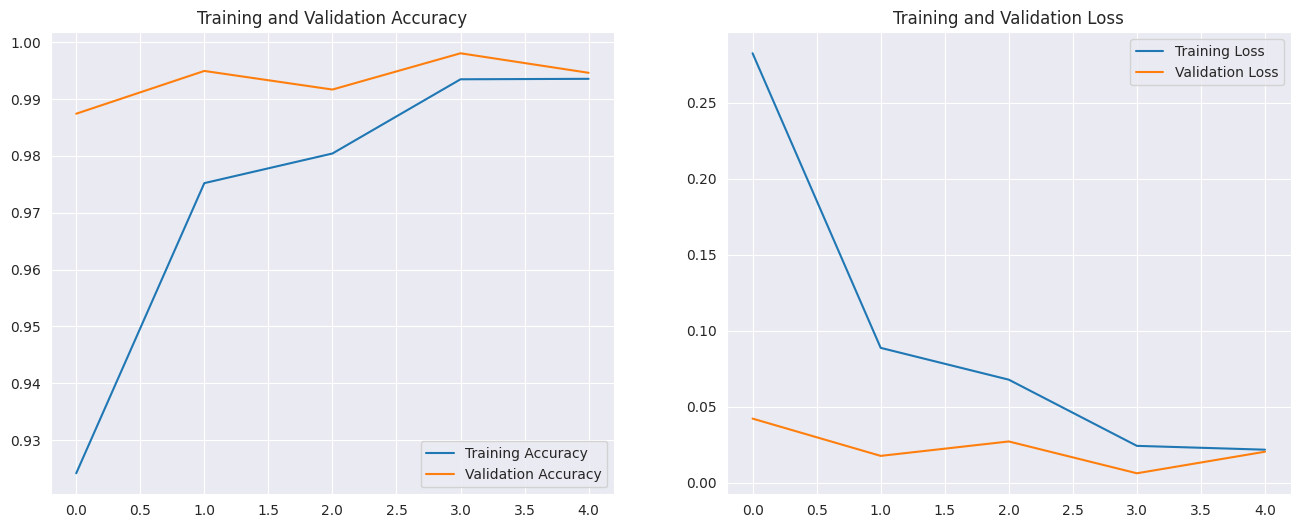

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save(base_dir + 'Models/InceptionResNetV2_1_v1.h5')

# InceptionResNetV2 with Imagenet

In [ ]:
# Define the input shape and number of classes
img_width, img_height = 128, 128
num_classes = 39

In [ ]:
# Load the pre-trained InceptionResNetV2 model, excluding the top layer
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [ ]:
# Add a custom top layer to the base model for our classification task
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze all layers in the base model so they are not trainable
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model with a categorical crossentropy loss function and an Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Set up data augmentation for training, validation, and test data
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)

In [ ]:
# Set up image generators for the training, validation, and test sets
train_generator = datagen.flow_from_directory(target_dir, target_size=(img_width, img_height), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(target_dir, target_size=(img_width, img_height), batch_size=32, class_mode='categorical', subset='validation')
test_generator = datagen.flow_from_directory(target_dir, target_size=(img_width, img_height), batch_size=32, class_mode='categorical', shuffle=False)

Found 48973 images belonging to 39 classes.
Found 12241 images belonging to 39 classes.
Found 61214 images belonging to 39 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
checkpoint = ModelCheckpoint(base_dir + 'callback_checkpoints/inception_imagenet_model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_delta=0.0001)

callback = [checkpoint, earlystop, reduce_lr]

In [ ]:
# Train the model for a specified number of epochs
epochs = 10
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks = callback)

Epoch 1/10
1531/1531 [==============================] - 427s 279ms/step - loss: 0.1231 - accuracy: 0.9703 - val_loss: 1.2169 - val_accuracy: 0.8684 - lr: 0.0010
Epoch 2/10
1531/1531 [==============================] - 422s 276ms/step - loss: 0.0973 - accuracy: 0.9760 - val_loss: 1.0163 - val_accuracy: 0.8840 - lr: 0.0010
Epoch 3/10
1531/1531 [==============================] - 418s 273ms/step - loss: 0.1019 - accuracy: 0.9745 - val_loss: 1.0104 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 4/10
1531/1531 [==============================] - 416s 272ms/step - loss: 0.0977 - accuracy: 0.9757 - val_loss: 1.2123 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 5/10
1531/1531 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.9783
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1531/1531 [==============================] - 420s 274ms/step - loss: 0.0931 - accuracy: 0.9783 - val_loss: 1.0287 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 6/10
1531/1531 [=========

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

1913/1913 [==============================] - 417s 218ms/step - loss: 0.1757 - accuracy: 0.9777
Test accuracy: 0.9776685237884521


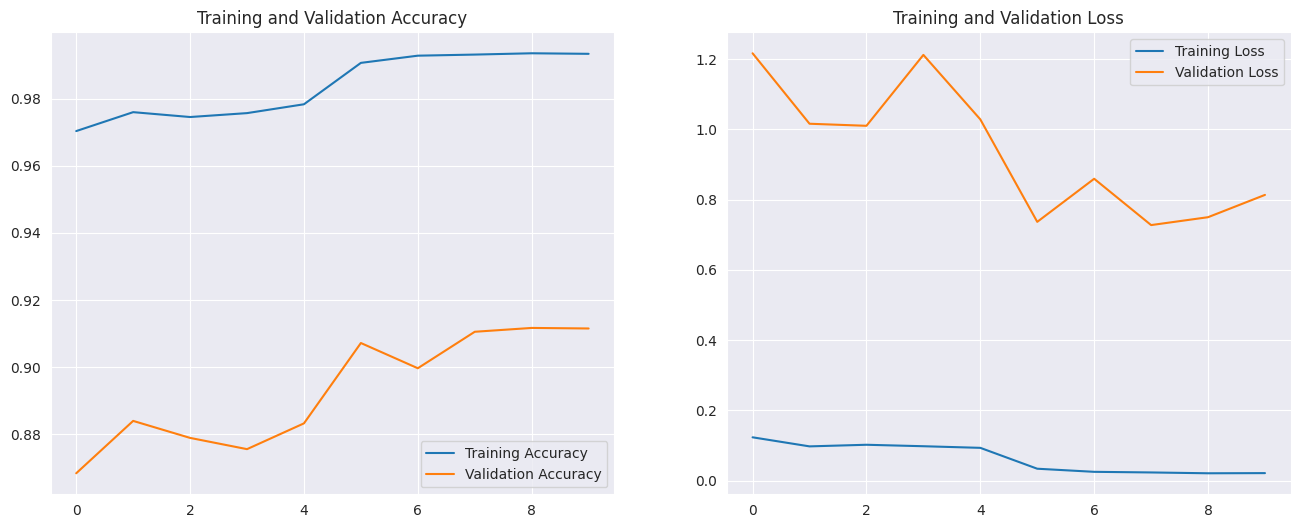

In [ ]:
# Plotting the accuracies and losses
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Saving the model
model.save(base_dir + 'Models/inception_imagenet_1_V2.h5')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Evaluate the model using a test generator
test_loss, test_acc = model.evaluate_generator(test_generator)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Generate predictions on the test generator
y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels from the test generator
y_true = test_generator.classes
print(y_true)
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(cm)

# Calculate the classification report
report = classification_report(y_true, y_pred)
print('Classification Report:')
print(report)

# Calculate the ROC curve and AUC score
# fpr, tpr, thresholds = roc_curve(y_true, y_pred)
# roc_auc = auc(fpr, tpr)
# print('ROC AUC Score:', roc_auc)


<ipython-input-25-5441c953a4b1>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator)


Test loss: 0.18211983144283295
Test accuracy: 0.9770640730857849


<ipython-input-25-5441c953a4b1>:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator)


[ 0  0  0 ... 38 38 38]
Confusion Matrix:
[[1569    0    0 ...    0    0    0]
 [   1 1561    1 ...    0    0    1]
 [   0    0 1563 ...    0    0    0]
 ...
 [   0    1    0 ... 1345    1    1]
 [   0    0    0 ...    0 1557    2]
 [   0    1    0 ...    0   22 1414]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1570
           1       1.00      0.99      1.00      1570
           2       0.99      1.00      0.99      1570
           3       1.00      1.00      1.00      1570
           4       1.00      1.00      1.00      1570
           5       1.00      1.00      1.00      1570
           6       1.00      0.99      0.99      1570
           7       0.99      1.00      0.99      1570
           8       1.00      0.99      1.00      1570
           9       0.99      1.00      0.99      1570
          10       0.95      0.99      0.97      1563
          11       0.97      0.99      0.98      1570
    

ValueError: ignored

In [ ]:
y_pred

array([ 0,  0,  0, ..., 38, 19,  1])